In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Description

In this project, we are interested in predicting and understanding delays in departure times for Brazilian airlines in domestic flights. There are three major companies, GOL, AZUL and TAM  which are denoted by the International Civil Aviation Organization (ICAO) abbreviation GLO, AZU, TAM. Here, we consider the data from 2018 - The National Civil Aviation Agency of Brazil (ANAC) has open data for all flights during that year. There are two different datasets, one that doesn't include the type of aircraft and another that does. Due to some inconsistencies, we will not merge them in one data frame, instead, we will use each dataset independently to see if aircraft type has any influence on the departure delays.

Note that departure delays can be separated into two independent types of delays: Propagated delays, which come from previous flights and intrinsic delays which are leg-dependent and has many components to them. The delay we experience in our everyday life is the sum of these two delays. Although in this project we regard only the total delay, a more complete dataset (with the whole Leg of each aircraft) can be used to distinguish the different delays and then use to predict the intrinsic delays.

## EDA

### Extracting data

First, we download the flight data into a new directory called 'data'. A small description of the data can be found in the project's folder, for more information see https://pergamum.anac.gov.br/arquivos/iac1504.pdf (in Portuguese).

After downloading the data, we merge all files into a single dataset while filtering the flight type ('N' for domestic) from the companies GOL, AZUL and TAM. The resulting dataset is exported to a new csv file ('total_data.csv').

We also read the national holidays from 2018 (available at https://www.anbima.com.br/feriados/fer_nacionais/2018.asp), and we transform it into a window of $\pm1$ days from the holiday. This guarantees that a pre/post-holiday increase in passengers will also be captured in the analysis.

In [2]:
import wget
from os import path,mkdir,listdir

In [39]:
#Check dir data 
if not path.exists('data'): mkdir('data')

#Read flights data
if path.exists('data/total_data.csv'):
    data_flight = pd.read_csv('data/total_data.csv')
else:
    print('Downloading files...\n')     
    filenames = ['vra-01_2018','vra-02_2018','vra_032018','vra_04','vra_05','vra_062018','vra_072018','vra_082018','vra_092018','vra_102018','vra_112018','vra_122018']
    for files in set([f+'.csv' for f in filenames]) - set(listdir('data/')): wget.download(f'https://www.gov.br/anac/pt-br/assuntos/dados-e-estatisticas/percentuais-de-atrasos-e-cancelamentos-2/2018/{files}', out=f'data\\{files}')

    colnames = ['ICAO_company','Flight_number','Autorization_code_DI','Flight_type','ICAO_departure','ICAO_arrival','Expected_departure','Departure','Expected_arrival','Arrival','Flight_status','Code_reasons']
    icao_keep = ['GLO','AZU','TAM']
    data_flight = pd.DataFrame(columns=colnames)
    print('Merging datasets...\n')  
    for files in filenames:
        temp_df= pd.read_csv(f'data\\{files}.csv', encoding = "ISO-8859-1",sep=';',names=colnames)
        temp_df = temp_df.loc[(temp_df['ICAO_company'].isin(icao_keep)) & (temp_df['Flight_type']=='N'),:]
        data_flight = pd.concat([data_flight,temp_df])
    data_flight = data_flight.drop(['Code_reasons','Flight_type'],axis=1)
    print('Saving datasets...\n') 
    data_flight.to_csv('data/total_data.csv',index=False)

#Read holiday data
if path.exists('data/holidays_2018.csv'):
    holidays_df = pd.read_csv('data/holidays_2018.csv')
    holidays_df['Day_before']= pd.to_datetime(holidays_df['Day_before'])
    holidays_df['Day_after']= pd.to_datetime(holidays_df['Day_after'])
else:
    holidays_df = pd.read_html('https://www.anbima.com.br/feriados/fer_nacionais/2018.asp')[2]
    holidays_df = holidays_df.rename(columns=holidays_df.loc[0]).loc[1:].drop(['Feriado','Dia da Semana'],axis=1)
    holidays_df['Day'] = pd.to_datetime(holidays_df['Data'], format='%d/%m/%y')
    holidays_df['Day_before'] = holidays_df['Day'] - pd.Timedelta(days =1)
    holidays_df['Day_after'] = holidays_df['Day'] + pd.Timedelta(days =1)
    holidays_df = holidays_df.drop(['Day','Data'],axis=1)
    holidays_df.to_csv('data/holidays_2018.csv',index=False)

C:\Users\rapha\AppData\Local\Temp\ipykernel_20196\186780493.py:6: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  data_flight = pd.read_csv('data/total_data.csv')


### Data cleaning

In [4]:
data_flight.head()

,ICAO_company,Flight_number,Autorization_code_DI,ICAO_departure,ICAO_arrival,Expected_departure,Departure,Expected_arrival,Arrival,Flight_status
0,GLO,4939,2,SBSP,SBSV,NaN,01/01/2018 11:50,NaN,01/01/2018 14:06,REALIZADO
1,GLO,4870,2,SBGR,SBPV,NaN,01/01/2018 20:35,NaN,02/01/2018 00:20,REALIZADO
2,GLO,2070,2,SBSP,SBGO,NaN,02/01/2018 11:17,NaN,02/01/2018 12:57,REALIZADO
3,GLO,2018,2,SBSP,SBFI,NaN,02/01/2018 13:12,NaN,02/01/2018 14:59,REALIZADO
4,GLO,2022,2,SBSP,SBFL,NaN,02/01/2018 19:07,NaN,02/01/2018 20:14,REALIZADO


The first thing that we can notice in the dataframe header is the missing values in Expected departure and arrival times, this is probably associated with a change in the flight schedule or some type of problem in the company's data. Since we are interested in the departure delay, we will ignore all rows with no Expected_departure. Not only that, we consider only the Flight_status 'REALIZADO' (completed) since 'CANCELADO' (cancelled) does not bring information about departure delays. 

In [40]:
data_flight=data_flight[(~data_flight['Expected_departure'].isna()) & (data_flight['Flight_status']=='REALIZADO')]
data_flight = data_flight.drop('Flight_status',axis=1)

In [41]:
data_flight.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 605892 entries, 15 to 631630
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   ICAO_company          605892 non-null  object
 1   Flight_number         605892 non-null  object
 2   Autorization_code_DI  605810 non-null  object
 3   ICAO_departure        605892 non-null  object
 4   ICAO_arrival          605892 non-null  object
 5   Expected_departure    605892 non-null  object
 6   Departure             605892 non-null  object
 7   Expected_arrival      605892 non-null  object
 8   Arrival               605892 non-null  object
dtypes: object(9)
memory usage: 46.2+ MB


To know if a flight is on-time, we use the condition that the real departure time is less than the expected departure plus 15 minutes,
$$ \text{Expected departure + 15 min} > \text{Departure},$$
When the above condition is satisfied, the flight is on-time (1) and in the negative case the flight is delayed (0). 

In order to verify this condition, we first transform the columns into DateTime.

In [42]:
data_flight['Expected_departure'] = pd.to_datetime(data_flight['Expected_departure'], format='%d/%m/%Y %H:%M')
data_flight['Departure'] = pd.to_datetime(data_flight['Departure'], format='%d/%m/%Y %H:%M')

In [43]:
mask_time = data_flight['Expected_departure'] + pd.Timedelta(minutes=15) > data_flight['Departure']
data_flight['On_time'] = 0
data_flight.loc[mask_time,'On_time'] = 1

Now, we split the expected departure data into months (categorical), days (integer), days of the week (categorical) and hours (integer). This way, we can obtain more precise information about the delay and if it is correlated with some of these variables. While month and day of the week are easy to understand how they could correlate (vacations/weekends increase the number of passengers), day and hour have intrinsic dynamics that can also affect the expected delay.

To simplify, here we consider only the "full hour", i.e. 19:45 and 19:05 are both considered 19.

In [44]:
data_flight['Expected_departure_month'] = data_flight['Expected_departure'].dt.strftime('%B')
data_flight['Expected_departure_day']= data_flight['Expected_departure'].dt.strftime('%d').astype(int)
data_flight['Expected_departure_day_week'] = data_flight['Expected_departure'].dt.strftime('%A')
data_flight['Expected_departure_hour'] = data_flight['Expected_departure'].dt.strftime('%H').astype(int)

We can also compute the expected flight length (Expected_arrival - Expected_departure),

In [45]:
data_flight['Flight_length'] = (pd.to_datetime(data_flight['Expected_arrival'], format='%d/%m/%Y %H:%M') - data_flight['Expected_departure'])/ np.timedelta64(1, 'm')

However, it is clear that some data are not correct as it has either a negative time or over 1000 minutes, which doesn't make sense for a domestic flight. Below, we show one such case. If we were to use the flight length, we will have to impose some conditions to avoid considering data with the wrong flight length.

In [46]:
data_flight.loc[505270]

ICAO_company                                   TAM
Flight_number                                 3750
Autorization_code_DI                             0
ICAO_departure                                SBGR
ICAO_arrival                                  SBEG
Expected_departure             2018-10-12 20:10:00
Departure                      2018-10-12 20:11:00
Expected_arrival                  12/10/2018 00:10
Arrival                           13/10/2018 00:01
On_time                                          1
Expected_departure_month                   October
Expected_departure_day                          12
Expected_departure_day_week                 Friday
Expected_departure_hour                         20
Flight_length                              -1200.0
Name: 505270, dtype: object

To conclude this section, we can verify if the flight is close to a national holiday ($\pm 1$ day), if this condition is satisfied we call 1 otherwise we say it's 0.
We also create a 'Leg' column which is given by the departure airport together with the arrival airport.

In [48]:
data_flight['Holidays'] = data_flight['Expected_departure'].apply(lambda t : 1 if len(holidays_df[(holidays_df.Day_before < t) & (holidays_df.Day_after > t)])>0 else 0 )

In [49]:
data_flight['Leg'] = data_flight['ICAO_departure'] +'-'+ data_flight['ICAO_arrival']

### Data Analysis

Before we start looking into the airlines' delays and how they depend on different variables, let's look into the amount of flight data we have for each company.

In [50]:
data_flight['ICAO_company'].value_counts()

AZU    227407
GLO    194161
TAM    184324
Name: ICAO_company, dtype: int64

The three companies have about the same amount of flights in 2018, and because of this, we can start thinking in terms of percentages, which will correspond to about the same amount.

Now we can look at the total on-time/delay for each company:

In [51]:
(data_flight
    .groupby('ICAO_company')['On_time']
    .value_counts(normalize=True)
    .unstack(level=0, fill_value=0)
)

ICAO_company,AZU,GLO,TAM
On_time,,,
0,0.113937,0.185599,0.173385
1,0.886063,0.814401,0.826615


We now can look into the distribution of delays over the months

In [52]:
month_order = ['January','February','March','April','May','June','July','August','September','October','November','December']

pd.DataFrame(data_flight[['On_time','ICAO_company','Expected_departure_month']]
    .groupby(['ICAO_company','Expected_departure_month'])
    .value_counts(normalize=True)
    .rename('percentage')
    .unstack(level=1, fill_value=0)).sort_values(by='On_time', ascending=False)[month_order]
    

,Expected_departure_month,January,February,March,April,May,June,July,August,September,October,November,December
ICAO_company,On_time,,,,,,,,,,,,
AZU,1,0.877087,0.908385,0.870587,0.903431,0.910945,0.893931,0.871569,0.918362,0.913085,0.871269,0.888828,0.818944
GLO,1,0.812290,0.900000,0.852737,0.861792,0.844712,0.809051,0.739773,0.887773,0.885335,0.861115,0.750771,0.685504
TAM,1,0.842115,0.868291,0.859628,0.896848,0.803450,0.860089,0.782393,0.851361,0.867714,0.839590,0.727337,0.762559
AZU,0,0.122913,0.091615,0.129413,0.096569,0.089055,0.106069,0.128431,0.081638,0.086915,0.128731,0.111172,0.181056
GLO,0,0.187710,0.100000,0.147263,0.138208,0.155288,0.190949,0.260227,0.112227,0.114665,0.138885,0.249229,0.314496
TAM,0,0.157885,0.131709,0.140372,0.103152,0.196550,0.139911,0.217607,0.148639,0.132286,0.160410,0.272663,0.237441


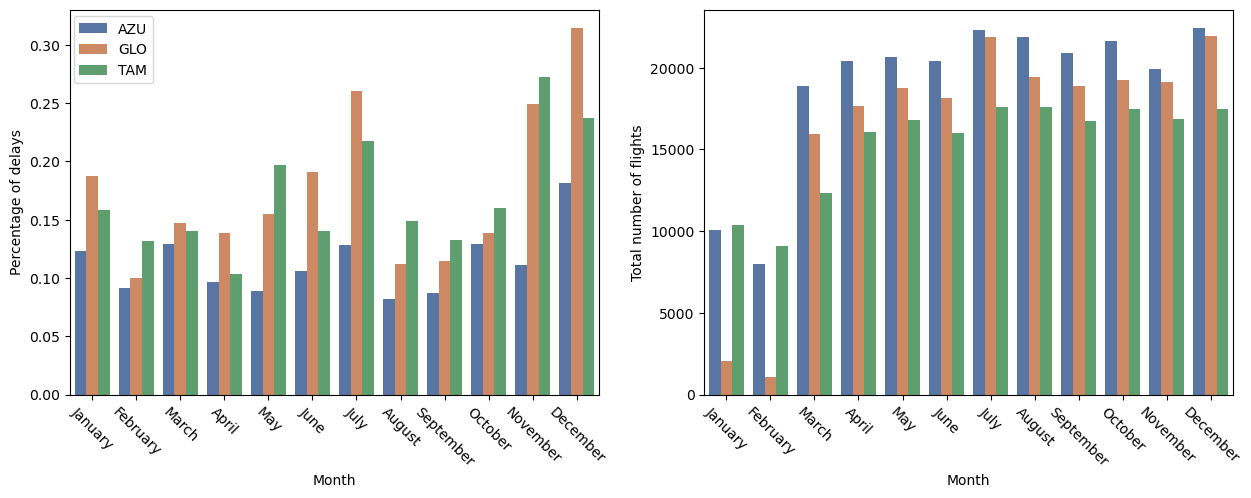

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

(data_flight[['On_time','ICAO_company','Expected_departure_month']]
    .groupby(['ICAO_company','Expected_departure_month'])
    .value_counts(normalize=True)
    .rename('percentage')
    .unstack(level=0, fill_value=0)
    .reset_index()
    .melt(id_vars = ['Expected_departure_month','On_time'], var_name='ICAO', value_name='percentage')
    .query('On_time == 0')
    .pipe((sns.barplot,'data'), x='Expected_departure_month',y='percentage',hue='ICAO', palette='deep',order=month_order, ax=axes[0])
)
axes[0].tick_params(axis='x', rotation=-45)
axes[0].legend(loc='best', bbox_to_anchor=(0.17, 1), ncol=1)
axes[0].set_ylabel('Percentage of delays')
axes[0].set_xlabel("Month")

(data_flight[['ICAO_company','Expected_departure_month']]
    .groupby(['ICAO_company','Expected_departure_month'])
    .value_counts()
    .rename('total')
    .unstack(level=0, fill_value=0)
    .reset_index()
    .melt(id_vars = ['Expected_departure_month'], var_name='ICAO', value_name='total')
    .pipe((sns.barplot,'data'), x='Expected_departure_month',y='total',hue='ICAO', palette='deep',order=month_order, ax=axes[1])
)
axes[1].tick_params(axis='x', rotation=-45)
axes[1].set_ylabel('Total number of flights')
axes[1].set_xlabel("Month")
axes[1].get_legend().remove()

As a side note, for some reason, all companies, in special GLO, have fewer flights in January/February. This is not exclusive to this dataset and is probably associated with a change in regulations and how the flights should be reported.

Now we can look into the distribution of delays over the days of the week

In [54]:
order_days=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

pd.DataFrame(data_flight[['On_time','ICAO_company','Expected_departure_day_week']]
    .groupby(['ICAO_company','Expected_departure_day_week'])
    .value_counts(normalize=True)
    .rename('percentage')
    .unstack(level=1, fill_value=0)).sort_values(by='On_time', ascending=False)[order_days]

,Expected_departure_day_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
ICAO_company,On_time,,,,,,,
AZU,1,0.881492,0.906185,0.896962,0.879822,0.862616,0.886123,0.889629
GLO,1,0.789351,0.858841,0.845884,0.774110,0.761571,0.851238,0.839222
TAM,1,0.843070,0.865356,0.831885,0.787617,0.776875,0.823139,0.865646
AZU,0,0.118508,0.093815,0.103038,0.120178,0.137384,0.113877,0.110371
GLO,0,0.210649,0.141159,0.154116,0.225890,0.238429,0.148762,0.160778
TAM,0,0.156930,0.134644,0.168115,0.212383,0.223125,0.176861,0.134354


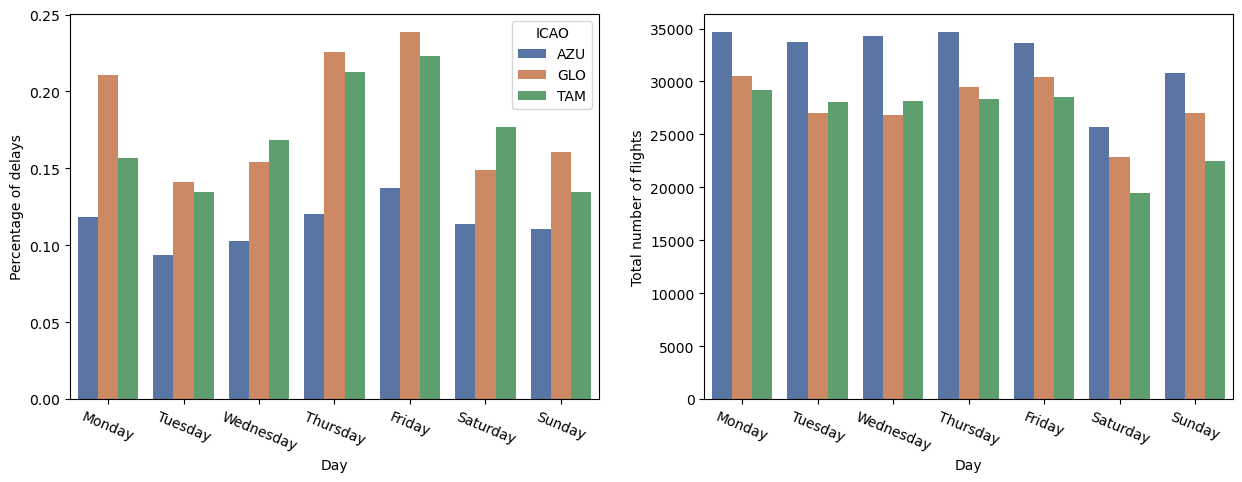

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

(data_flight[['On_time','ICAO_company','Expected_departure_day_week']]
    .groupby(['ICAO_company','Expected_departure_day_week'])
    .value_counts(normalize=True)
    .rename('percentage')
    .unstack(level=0, fill_value=0)
    .reset_index()
    .melt(id_vars = ['Expected_departure_day_week','On_time'], var_name='ICAO', value_name='percentage')
    .query('On_time == 0')
    .pipe((sns.barplot,'data'), x='Expected_departure_day_week',y='percentage',hue='ICAO', palette='deep',order=order_days, ax=axes[0])
)
axes[0].tick_params(axis='x', rotation=-22.5)
axes[0].set_ylabel('Percentage of delays')
axes[0].set_xlabel("Day")

(data_flight[['ICAO_company','Expected_departure_day_week']]
    .groupby(['ICAO_company','Expected_departure_day_week'])
    .value_counts()
    .rename('total')
    .unstack(level=0, fill_value=0)
    .reset_index()
    .melt(id_vars = ['Expected_departure_day_week'], var_name='ICAO', value_name='total')
    .pipe((sns.barplot,'data'), x='Expected_departure_day_week',y='total',hue='ICAO', palette='deep',order=order_days, ax=axes[1])
)
axes[1].tick_params(axis='x', rotation=-22.5)
axes[1].set_ylabel('Total number of flights')
axes[1].set_xlabel("Day")
axes[1].get_legend().remove()

Also over the days of the month

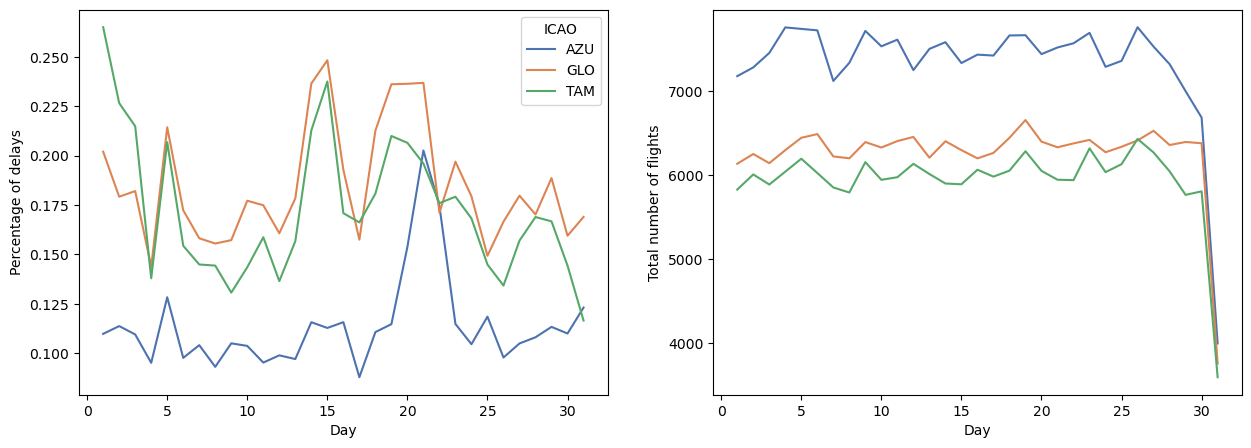

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

(data_flight[['On_time','ICAO_company','Expected_departure_day']]
    .groupby(['ICAO_company','Expected_departure_day'])
    .value_counts(normalize=True)
    .rename('percentage')
    .unstack(level=0, fill_value=0)
    .reset_index()
    .melt(id_vars = ['Expected_departure_day','On_time'], var_name='ICAO', value_name='percentage')
    .query('On_time == 0')
    .pipe((sns.lineplot,'data'), x='Expected_departure_day',y='percentage',hue='ICAO', palette='deep', ax=axes[0])
)
axes[0].set_ylabel('Percentage of delays')
axes[0].set_xlabel("Day")

(data_flight[['ICAO_company','Expected_departure_day']]
    .groupby(['ICAO_company','Expected_departure_day'])
    .value_counts()
    .rename('Total')
    .unstack(level=0, fill_value=0)
    .reset_index()
    .melt(id_vars = ['Expected_departure_day'], var_name='ICAO', value_name='Total')
    .pipe((sns.lineplot,'data'), x='Expected_departure_day',y='Total',hue='ICAO', palette='deep', ax=axes[1])
)
axes[1].set_ylabel('Total number of flights')
axes[1].set_xlabel("Day")
axes[1].get_legend().remove()

And to conclude this segment, over the hours

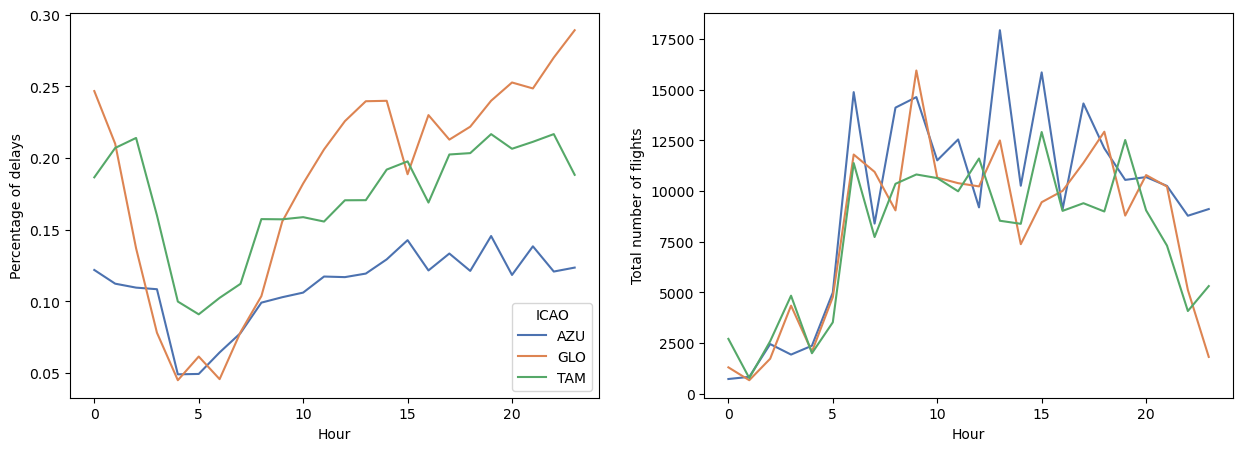

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

(data_flight[['On_time','ICAO_company','Expected_departure_hour']]
    .groupby(['ICAO_company','Expected_departure_hour'])
    .value_counts(normalize=True)
    .rename('percentage')
    .unstack(level=0, fill_value=0)
    .reset_index()
    .melt(id_vars = ['Expected_departure_hour','On_time'], var_name='ICAO', value_name='percentage')
    .query('On_time == 0')
    .pipe((sns.lineplot,'data'), x='Expected_departure_hour',y='percentage',hue='ICAO', palette='deep', ax=axes[0])
)
axes[0].set_ylabel('Percentage of delays')
axes[0].set_xlabel("Hour")

(data_flight[['ICAO_company','Expected_departure_hour']]
    .groupby(['ICAO_company','Expected_departure_hour'])
    .value_counts()
    .rename('Total')
    .unstack(level=0, fill_value=0)
    .reset_index()
    .melt(id_vars = ['Expected_departure_hour'], var_name='ICAO', value_name='Total')
    .pipe((sns.lineplot,'data'), x='Expected_departure_hour',y='Total',hue='ICAO', palette='deep', ax=axes[1])
)
axes[1].set_ylabel('Total number of flights')
axes[1].set_xlabel("Hour")
axes[1].get_legend().remove()

Now we can look into the influence of national holidays on delays. The first thing we should look at is the number of flights during all holidays for each company

In [58]:
(data_flight[['ICAO_company','Holidays']]
    .groupby(['ICAO_company','Holidays'])
    .value_counts()
    .rename('Total')
    .unstack(level=0, fill_value=0)
    .reset_index()
    .melt(id_vars = ['Holidays'], var_name='ICAO', value_name='Total')
    .sort_values(by='Holidays',ascending=False))

,Holidays,ICAO,Total
1,1,AZU,11736
3,1,GLO,11422
5,1,TAM,11387
0,0,AZU,215671
2,0,GLO,182739
4,0,TAM,172937


The three companies have about the same number of flights, so we can still easily compare the delays in terms of percentages. To see the effect of holidays, we can plot the delays on national holidays and compare them to normal days

In [59]:
(data_flight[['On_time','ICAO_company','Holidays']]
    .groupby(['ICAO_company','Holidays'])
    .value_counts(normalize=True)
    .rename('percentage')
    .unstack(level=0, fill_value=0)
    .reset_index()
    .melt(id_vars = ['Holidays','On_time'], var_name='ICAO', value_name='percentage')
    .query('On_time == 0')
)

,Holidays,On_time,ICAO,percentage
0,0,0,AZU,0.114638
2,1,0,AZU,0.101057
4,0,0,GLO,0.185762
6,1,0,GLO,0.182980
8,0,0,TAM,0.169380
10,1,0,TAM,0.234214


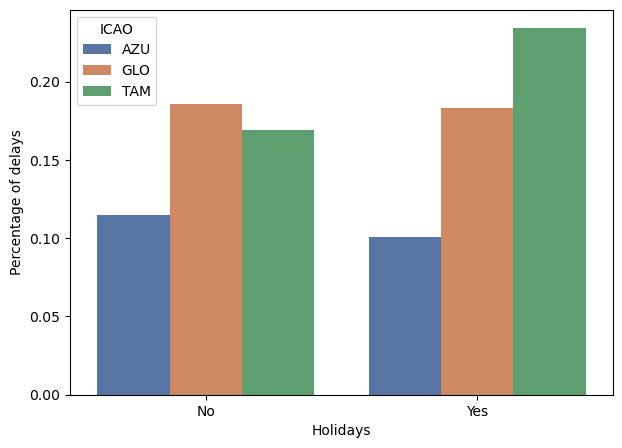

In [60]:
fig, axes = plt.subplots(1, 1, figsize=(7,5))

(data_flight[['On_time','ICAO_company','Holidays']]
    .groupby(['ICAO_company','Holidays'])
    .value_counts(normalize=True)
    .rename('percentage')
    .unstack(level=0, fill_value=0)
    .reset_index()
    .melt(id_vars = ['Holidays','On_time'], var_name='ICAO', value_name='percentage')
    .query('On_time == 0')
    .pipe((sns.barplot,'data'), x='Holidays',y='percentage',hue='ICAO', palette='deep', ax=axes)
)
axes.set_ylabel('Percentage of delays')
axes.set_xticklabels(['No','Yes']);

Before we look into the effects of flight length on the delays, we can first look into the distribution of flight lengths for each company. To avoid any potential outliner, we look only into the interval (0,300). As it turns out, Azul is mainly focused on short-haul flights while both Gol and Latam have, proportionally, longer flights.

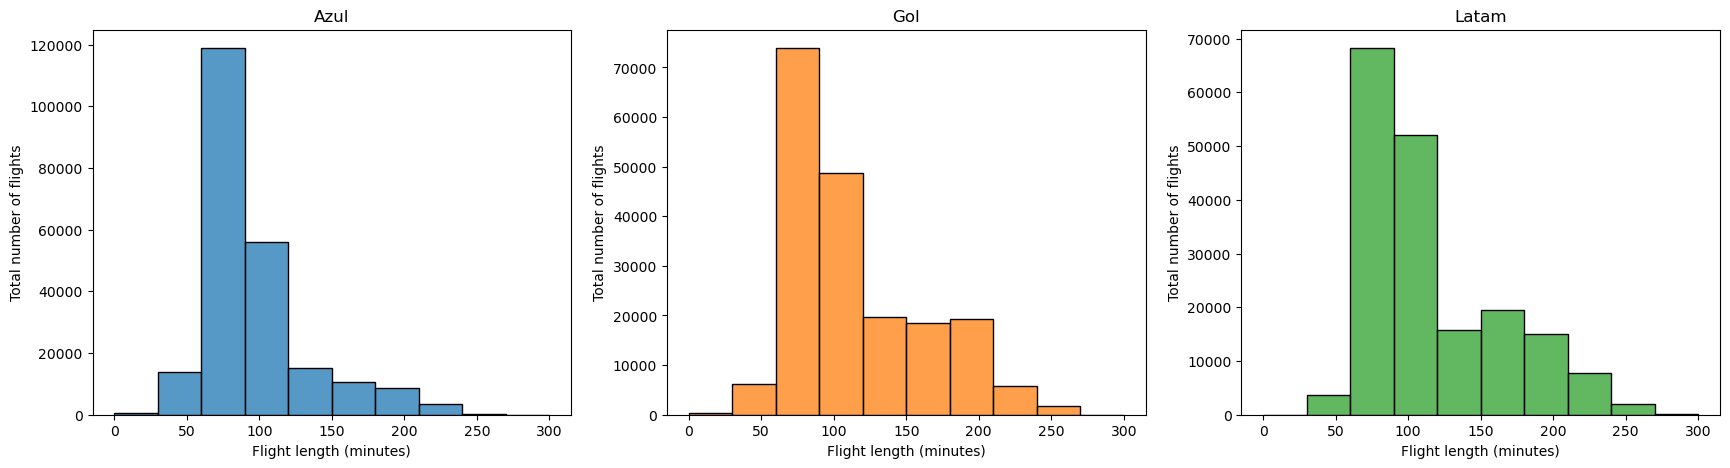

In [61]:
fig, axes = plt.subplots(1, 3, figsize=(21,5))
icao=['AZU','GLO','TAM']
compan = ['Azul','Gol','Latam']
for k,comp in enumerate(icao):
    sns.histplot(data = data_flight[(data_flight['ICAO_company']==comp)],
                 x='Flight_length',bins=10, ax=axes[k],binrange=(0,300),color=sns.color_palette()[k])
    axes[k].set_ylabel('Total number of flights')
    axes[k].set_xlabel("Flight length (minutes)")
    axes[k].set_title(compan[k])

We can use a boxplot to visualize the effect of flight length distribution on the delays/on-time flights

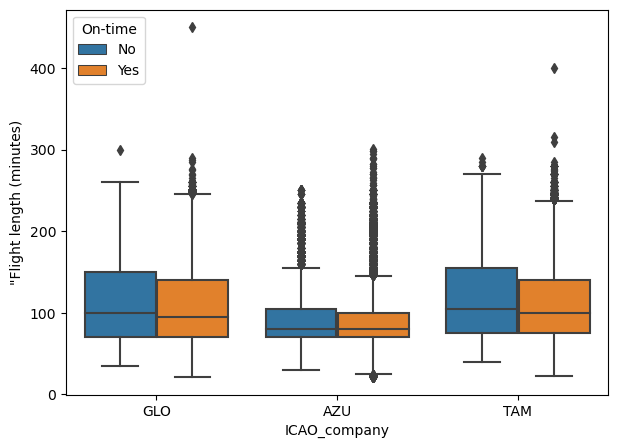

In [64]:
fig, axes = plt.subplots(1, 1, figsize=(7,5))
sns.boxplot(data = data_flight[(20<data_flight['Flight_length']) & (data_flight['Flight_length']<1000)], hue='On_time', y='Flight_length', x= 'ICAO_company', order=['GLO','AZU','TAM'],ax = axes)
axes.set_ylabel('Flight length (minutes)')
axes.legend(handles=axes.get_legend_handles_labels()[0], labels=['No','Yes'],title='On-time')

Now we shift the focus from quantitative to qualitative (categorical) data.

A relevant question in trying to determine the delays is how much airports (both at the departure and arrival) can influence the departure delays. To answer this question we can look into the airports with the highest percentages of delays for each company. Here we will focus on one company only, say GOL (which had the highest amount of delays in 2018).

First, we can look into the departure airport with the highest percentage of delays for GOL and how it compares with the overall delay of all companies together (including GOL)


In [65]:
data_less_or = (data_flight[(data_flight['ICAO_company']=='GLO')][['On_time','ICAO_departure']]
    .groupby('ICAO_departure')
    .value_counts(normalize=True)
    .unstack(level=1, fill_value=0)
    .sort_values(by=1, ascending=True)
    .rename(columns={0:'percentage_delay',1:'percentage_On_time'})
)

data_less_or['Total_flights_Gol'] = data_flight[(data_flight['ICAO_company']=='GLO')][['ICAO_departure']].groupby('ICAO_departure').value_counts()
data_less_or['Total_delay_percentage'] = data_flight[['ICAO_departure','On_time']].groupby('ICAO_departure').value_counts(normalize=True).unstack(level=1, fill_value=0)[0]
data_less_or[:8]

On_time,percentage_delay,percentage_On_time,Total_flights_Gol,Total_delay_percentage
ICAO_departure,,,,
SBCJ,0.288136,0.711864,295,0.161329
SBBE,0.270349,0.729651,3440,0.208751
SBIL,0.263768,0.736232,345,0.173889
SBRP,0.260870,0.739130,46,0.128713
SBPA,0.244436,0.755564,8313,0.168952
SBBV,0.239583,0.760417,288,0.232990
SBGR,0.233616,0.766384,24429,0.218193
SBJP,0.223012,0.776988,1547,0.200445


We can do the same analysis for arrival airports

In [66]:
data_less_dest = (data_flight[(data_flight['ICAO_company']=='GLO')][['On_time','ICAO_arrival']]
.groupby('ICAO_arrival')
.value_counts(normalize=True)
.unstack(level=1, fill_value=0)
.sort_values(by=1, ascending=True)
.rename(columns={0:'percentage_delay',1:'percentage_On_time'})
)

data_less_dest['Total_flights'] = data_flight[(data_flight['ICAO_company']=='GLO')][['ICAO_arrival']].groupby('ICAO_arrival').value_counts()
data_less_dest['Total_delay_percentage'] = data_flight[['ICAO_arrival','On_time']].groupby('ICAO_arrival').value_counts(normalize=True).unstack(level=1, fill_value=0)[0]
data_less_dest[:8]

On_time,percentage_delay,percentage_On_time,Total_flights,Total_delay_percentage
ICAO_arrival,,,,
SBPL,0.442982,0.557018,228,0.199063
SBJU,0.379928,0.620072,279,0.169872
SBMK,0.319549,0.680451,266,0.158247
SBCJ,0.306122,0.693878,294,0.176048
SBMQ,0.259259,0.740741,567,0.230284
SBNF,0.238429,0.761571,2571,0.175286
SBCG,0.236006,0.763994,1322,0.156540
SBSL,0.230459,0.769541,1241,0.146877


To conclude this section, we look into leg-dependent delays

In [67]:
data_less_rot = (data_flight[(data_flight['ICAO_company']=='GLO')][['On_time','Leg']]
    .groupby('Leg')
    .value_counts(normalize=True)
    .unstack(level=1, fill_value=0)
    .sort_values(by=1, ascending=True)
    .rename(columns={0:'percentage_delay',1:'percentage_On_time'})
)

data_less_rot['Total_flights_Gol'] = data_flight[(data_flight['ICAO_company']=='GLO')][['Leg']].groupby('Leg').value_counts()
data_less_rot['Total_delay_percentage'] = data_flight[['Leg','On_time']].groupby('Leg').value_counts(normalize=True).unstack(level=1, fill_value=0)[0]
data_less_rot[:8]

On_time,percentage_delay,percentage_On_time,Total_flights_Gol,Total_delay_percentage
Route,,,,
SBPS-SBPJ,1.000000,0.000000,1,1.000000
SBPS-SBCG,1.000000,0.000000,1,0.333333
SBEG-SBPA,1.000000,0.000000,1,1.000000
SBPS-SBFI,1.000000,0.000000,1,1.000000
SBPS-SBLO,0.750000,0.250000,4,0.750000
SBIL-SBGL,0.750000,0.250000,4,0.750000
SBJU-SBFZ,0.740741,0.259259,27,0.740741
SBLO-SBPS,0.666667,0.333333,3,0.666667


The legs shown above are not representatives since they have very few flights. We can look only at legs with more than 100 flights (about 2 per week)

In [68]:
data_less_rot = (data_flight[(data_flight['ICAO_company']=='GLO')][['On_time','Leg']]
    .groupby('Leg')
    .value_counts(normalize=True)
    .unstack(level=1, fill_value=0)
    .sort_values(by=1, ascending=True)
    .rename(columns={0:'percentage_delay',1:'percentage_On_time'})
)

data_less_rot['Total_flights_Gol'] = data_flight[(data_flight['ICAO_company']=='GLO')][['Leg']].groupby('Leg').value_counts()
data_less_rot['Total_delay_percentage'] = data_flight[['Leg','On_time']].groupby('Leg').value_counts(normalize=True).unstack(level=1, fill_value=0)[0]
data_less_rot[data_less_rot['Total_flights_Gol']>100][:8]

On_time,percentage_delay,percentage_On_time,Total_flights_Gol,Total_delay_percentage
Route,,,,
SBJP-SBSV,0.611111,0.388889,108,0.611111
SBGR-SBPV,0.523364,0.476636,107,0.424342
SBGR-SBPL,0.448889,0.551111,225,0.448889
SBSV-SBJP,0.429907,0.570093,107,0.429907
SBSV-SBCF,0.396907,0.603093,388,0.211118
SBBE-SBGR,0.375367,0.624633,682,0.275353
SBGR-SBJU,0.357143,0.642857,252,0.357143
SBGR-SBSL,0.354839,0.645161,341,0.283168


 ## Delay prediction

Here we use months and days of the week as categorical data, this improves the model's flexibility as well as the model doesn't group close months (say July and August) together when they have very distinct behaviour, this is important since some months have more passengers (summer vacation for instance) while close months might not have it. Days of the week have similar behaviour with Friday-Monday having a different delay behaviour than Tueday-Thursday. 

Another important remark is that both the day of the month and the hour are not considered cyclic variables. It is not clear the gains it would introduce, on the other hand, it could have some information leak between two very distinct times (say 22h and 6h).

The analysis/comparison between different models is done at the end of this section

### Simple model

Here we use the same flight length restriction used before in the data analysis and we remove unnecessary columns

In [78]:
droplist =  ['Flight_number','Autorization_code_DI','Expected_arrival','Expected_departure','Departure','Arrival','Leg']
data_model = data_flight[(20<data_flight['Flight_length']) & (data_flight['Flight_length']<1000)].drop(droplist,axis=1)
data_model = pd.get_dummies(data_model,drop_first=True)

Now we can scale the data such that it will be between 0 and 1 (flight length, day and hour) and we also split the dataset into train and test data. 

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import MinMaxScaler
x_scaler = MinMaxScaler()
data_model[['Flight_length','Expected_departure_day','Expected_departure_hour']]= x_scaler.fit_transform(data_model[['Flight_length','Expected_departure_day','Expected_departure_hour']])

X = data_model.drop(['On_time'],axis=1).values
Y = data_model['On_time'].values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3)

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, Y_train)
rfc_pred = rfc.predict(X_test)

In [379]:
print(confusion_matrix(Y_test,rfc_pred))
print(classification_report(Y_test,rfc_pred))

[[  5028  22975]
 [  4729 148754]]
              precision    recall  f1-score   support

           0       0.52      0.18      0.27     28003
           1       0.87      0.97      0.91    153483

    accuracy                           0.85    181486
   macro avg       0.69      0.57      0.59    181486
weighted avg       0.81      0.85      0.81    181486



In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from keras.layers import LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping

In [34]:
model = Sequential()
model.add(Dense(200, input_dim = X_train.shape[1], activation = 'relu'))
model.add(Dense(200, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(200, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss="BinaryCrossentropy", optimizer= "adam", metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [382]:
model.fit(x=X_train, 
          y=Y_train, 
          epochs=25,
          batch_size=800,
          validation_data=(X_test, Y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/25
530/530 [==============================] - 6s 9ms/step - loss: 0.4132 - accuracy: 0.8443 - val_loss: 0.3985 - val_accuracy: 0.8474
Epoch 2/25
530/530 [==============================] - 4s 7ms/step - loss: 0.3977 - accuracy: 0.8469 - val_loss: 0.3925 - val_accuracy: 0.8489
Epoch 3/25
530/530 [==============================] - 4s 7ms/step - loss: 0.3911 - accuracy: 0.8486 - val_loss: 0.3895 - val_accuracy: 0.8491
Epoch 4/25
530/530 [==============================] - 4s 7ms/step - loss: 0.3860 - accuracy: 0.8499 - val_loss: 0.3872 - val_accuracy: 0.8504
Epoch 5/25
530/530 [==============================] - 4s 7ms/step - loss: 0.3811 - accuracy: 0.8509 - val_loss: 0.3857 - val_accuracy: 0.8509
Epoch 6/25
530/530 [==============================] - 4s 7ms/step - loss: 0.3773 - accuracy: 0.8519 - val_loss: 0.3846 - val_accuracy: 0.8509
Epoch 7/25
530/530 [==============================] - 4s 7ms/step - loss: 0.3732 - accuracy: 0.8533 - val_loss: 0.3843 - val_accuracy: 0.8509
Epoch 

<AxesSubplot: >

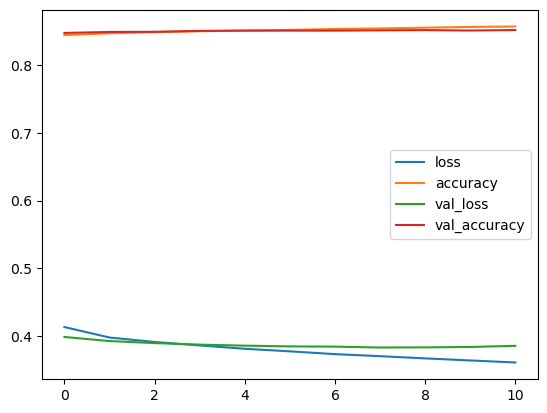

In [383]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [384]:
predictions = model.predict(X_test)
print(confusion_matrix(Y_test,np.round(predictions)))
print(classification_report(Y_test,np.round(predictions)))

5672/5672 [==============================] - 5s 799us/step
[[  3185  24818]
 [  2098 151385]]
              precision    recall  f1-score   support

           0       0.60      0.11      0.19     28003
           1       0.86      0.99      0.92    153483

    accuracy                           0.85    181486
   macro avg       0.73      0.55      0.55    181486
weighted avg       0.82      0.85      0.81    181486



### Can we improve?

In another dataset, the National Civil Aviation Agency of Brazil also shows the aircraft type and the number of seats. In this section, we use this second dataset to show aircraft type/number of seats can significantly improve the delay prediction.

We use this dataset independently from the previous one as it has some incompatibilities, which could add extra noise when we analyzed the data.

This dataset is available at  https://siros.anac.gov.br/siros/registros/diversos/vra/2018/


Now, we can repeat the same data processing done before

In [81]:
#Check dir data2
if not path.exists('data2'): mkdir('data2')

#Read flights data
if path.exists('data2/total_data2.csv'):
    data_flight2 = pd.read_csv('data2/total_data2.csv')
else:
    print('Downloading files...\n')     
    filenames = filenames = ['VRA_2018_'+str(i).zfill(2) for i in range(1,13)]
    for files in set([f+'.csv' for f in filenames]) - set(listdir('data2/')): wget.download(f'https://siros.anac.gov.br/siros/registros/diversos/vra/2018/{files}', out=f'data2\\{files}')

    colnames = ['ICAO_company','Company','Flight_number','DI_Code','Flight_type','Aircraft','Seats','ICAO_departure','Airport_departure','Expected_departure','Departure','ICAO_arrival','Airport_arrival','Expected_arrival','Arrival','Flight_status','Reason','Reference','Status_departure','Status_arrival']
    icao_keep = ['GLO','AZU','TAM']
    data_flight2 = pd.DataFrame(columns=colnames)
    print('Merging datasets...\n')  
    for files in filenames:
        temp_df= pd.read_csv(f'data2\\{files}.csv',sep=';',names=colnames)
        temp_df = temp_df.loc[(temp_df['ICAO_company'].isin(icao_keep)) & (temp_df['Flight_type']=='N'),:]
        data_flight2 = pd.concat([data_flight2,temp_df])
    print('Saving datasets...\n') 
    data_flight2.to_csv('data2/total_data2.csv',index=False)

C:\Users\rapha\AppData\Local\Temp\ipykernel_20196\1003907646.py:6: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data_flight2 = pd.read_csv('data2/total_data2.csv')


In [ ]:
import wget
from os import path,mkdir
if not path.exists('data2'): mkdir('data2')
filenames = ['VRA_2018_'+str(i).zfill(2) for i in range(1,13)]
for files in filenames: wget.download(f'https://siros.anac.gov.br/siros/registros/diversos/vra/2018/{files}.csv', out='data2\\'+files+'.csv')

colnames = ['Sigla ICAO_company','Company','Flight_number','DI_Code','Flight_type','Aircraft','Seats','ICAO_departure','Airport_departure','Expected_departure','Departure','ICAO_arrival','Airport_arrival','Expected_arrival','Arrival','Flight_status','Reason','Reference','Status_departure','Status_arrival']
icao_keep = ['GLO','AZU','TAM']
data_flight2 = pd.DataFrame(columns=colnames)
for files in filenames:
    temp_df= pd.read_csv(f'data2\\{files}.csv',sep=';')
    temp_df = temp_df.loc[(temp_df['Sigla ICAO_company'].isin(icao_keep)) & (temp_df['Flight_type']=='N'),:]
    data_flight2 = pd.concat([data_flight2,temp_df])
data_flight2.to_csv('total2_data.csv',index=False)

In [35]:
data_flight2 = pd.read_csv('total2_data.csv')

C:\Users\rapha\AppData\Local\Temp\ipykernel_11512\1741065633.py:1: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data_flight2 = pd.read_csv('total2_data.csv')


In [82]:
data_flight2 = data_flight2[(~data_flight2['Expected_departure'].isna()) & (data_flight2['Flight_status']=='REALIZADO')]
data_flight2 = data_flight2.drop(['Company','Flight_number','DI_Code','Flight_type','Airport_departure','Airport_arrival','Reason','Reference','Status_departure','Status_arrival','Flight_status'], axis=1)
data_flight2 = data_flight2.dropna()

In [83]:
data_flight2['Expected_departure'] = pd.to_datetime(data_flight2['Expected_departure'], format='%d/%m/%Y %H:%M')
data_flight2['Departure'] = pd.to_datetime(data_flight2['Departure'], format='%d/%m/%Y %H:%M')

mask_time = data_flight2['Expected_departure'] + pd.Timedelta(minutes=15) > data_flight2['Departure']
data_flight2['On_time'] = 0
data_flight2.loc[mask_time,'On_time'] = 1

data_flight2['Expected_departure_month'] = data_flight2['Expected_departure'].dt.strftime('%B')
data_flight2['Expected_departure_day']= data_flight2['Expected_departure'].dt.strftime('%d').astype(int)
data_flight2['Expected_departure_day_week'] = data_flight2['Expected_departure'].dt.strftime('%A')
data_flight2['Expected_departure_hour'] = data_flight2['Expected_departure'].dt.strftime('%H').astype(int)

data_flight2['Flight_length'] = (pd.to_datetime(data_flight2['Expected_arrival'], format='%d/%m/%Y %H:%M') - data_flight2['Expected_departure'])/ np.timedelta64(1, 'm')

data_flight2['Holidays'] = data_flight2['Expected_departure'].apply(lambda t : 1 if len(holidays_df[(holidays_df.Day_before < t) & (holidays_df.Day_after > t)])>0 else 0 )

data_model2 = data_flight2[(20<data_flight2['Flight_length']) & (data_flight2['Flight_length']<1000)].drop(['Expected_departure','Departure','Expected_arrival','Arrival'],axis=1)
data_model2 = pd.get_dummies(data_model2,drop_first=True)

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import MinMaxScaler
x_scaler = MinMaxScaler()
data_model2[['Seats','Flight_length','Expected_departure_day','Expected_departure_hour']]= x_scaler.fit_transform(data_model2[['Seats','Flight_length','Expected_departure_day','Expected_departure_hour']])

X = data_model2.drop(['On_time'],axis=1).values
Y = data_model2['On_time'].values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3)

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [389]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, Y_train)
rfc_pred = rfc.predict(X_test)

print(confusion_matrix(Y_test,rfc_pred))
print(classification_report(Y_test,rfc_pred))

[[  5333  21999]
 [  4942 138758]]
              precision    recall  f1-score   support

           0       0.52      0.20      0.28     27332
           1       0.86      0.97      0.91    143700

    accuracy                           0.84    171032
   macro avg       0.69      0.58      0.60    171032
weighted avg       0.81      0.84      0.81    171032



In [390]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [391]:
model = Sequential()
model.add(Dense(259, input_dim = X_train.shape[1], activation = 'relu'))
model.add(Dense(250, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(250, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss="BinaryCrossentropy", optimizer= "adam", metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)


In [392]:
model.fit(x=X_train, 
          y=Y_train, 
          epochs=25,
          batch_size=200,
          validation_data=(X_test, Y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/25
1996/1996 [==============================] - 10s 4ms/step - loss: 0.4108 - accuracy: 0.8423 - val_loss: 0.4002 - val_accuracy: 0.8442
Epoch 2/25
1996/1996 [==============================] - 8s 4ms/step - loss: 0.3970 - accuracy: 0.8453 - val_loss: 0.3977 - val_accuracy: 0.8448
Epoch 3/25
1996/1996 [==============================] - 8s 4ms/step - loss: 0.3900 - accuracy: 0.8467 - val_loss: 0.3959 - val_accuracy: 0.8465
Epoch 4/25
1996/1996 [==============================] - 8s 4ms/step - loss: 0.3837 - accuracy: 0.8479 - val_loss: 0.3920 - val_accuracy: 0.8463
Epoch 5/25
1996/1996 [==============================] - 8s 4ms/step - loss: 0.3784 - accuracy: 0.8490 - val_loss: 0.3910 - val_accuracy: 0.8461
Epoch 6/25
1996/1996 [==============================] - 9s 5ms/step - loss: 0.3729 - accuracy: 0.8511 - val_loss: 0.3900 - val_accuracy: 0.8456
Epoch 7/25
1996/1996 [==============================] - 9s 4ms/step - loss: 0.3678 - accuracy: 0.8524 - val_loss: 0.3943 - val_accuracy

<AxesSubplot: >

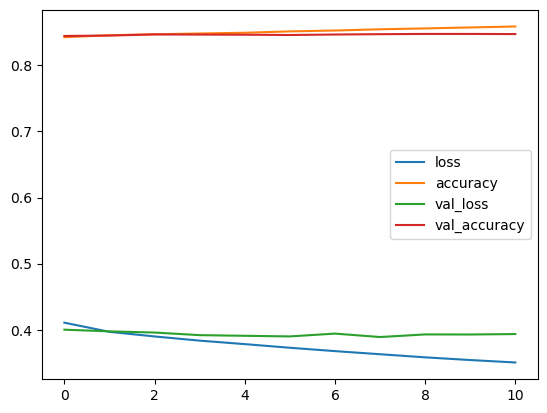

In [393]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [395]:
predictions = model.predict(X_test)
print(confusion_matrix(Y_test,np.round(predictions)))
print(classification_report(Y_test,np.round(predictions)))

5345/5345 [==============================] - 4s 727us/step
[[  4025  23307]
 [  2852 140848]]
              precision    recall  f1-score   support

           0       0.59      0.15      0.24     27332
           1       0.86      0.98      0.92    143700

    accuracy                           0.85    171032
   macro avg       0.72      0.56      0.58    171032
weighted avg       0.81      0.85      0.81    171032



### Model analysis:

We have 4 models and their respective confusion matrices:

<table ><tr><td >No Aircraft // Random Forest:<br/> <center>[[  5028  22975]<br /> [  4729 148754]] </center><td> Aircraft // Random Forest:<br/><center>[[  5333  21999]<br/> [  4942 138758]]</center><tr>
<tr><td> No Aircraft // Neural Network: <br/><center>[[  3185  24818]<br/> [  2098 151385]] </center><td> Aircraft // Neural Network:<br/><center>[[  4025  23307]<br/> [  2852 140848]]</center></table>

Here, we are interested in the ability to predict delays, and if possible, take preventive measures to avoid them. Because of this, we are interested in the recall metric $$\text{recall}=\frac{\text{True positives}}{\text{True positive + False negative}}.$$

When we compare the models, is trivial to see that all of them have to recall $\leq0.2$, this means that the models above can predict only 20% of delays that happens. Here, the model with the best performance was Random Forest with aircraft, recall = 0.2. It is worth mentioning that neural network models have better performance when predicting on-time variables.

One simple way to improve the prediction's quality is to consider each company independently, this way we avoid information leakage between different companies that have different dynamics (as shown in the analysis of airports). Take for instance the GOL case. When we use only GOL's flight, the Random Forest without aircraft has recall of 0.25 instead of 0.18. When we consider aircraft, the recall jumps from 0.2 to 0.29. Ideally, to improve the delay prediction we need to consider other variables such as the number of passengers, abnormal status in the airport, weather, etc. Note that we won't be able to predict all delays since the model we consider here doesn't take into account the aircraft route and propagated delays from previous legs.

To conclude, we also point out that the inclusion of legs in the model doesn't improve the prediction's quality, on the other hand, it takes almost 6 times the time to run any machine learning algorithm. Because of this, we choose to remove the legs from the models above. This doesn't mean that specific legs don't influence the delay, it only means that for some legs we don't have enough data which can worsen the model's prediction capabilities. 